### Problem statement/ proposed solution metrics

In this notebook, we will attempt to address the problem task at hand defined by PASSNYC:
* There is a vast ethnic disparity in the percentage of registering for/ clearing SHSAT and hence resulting lack of diversity in the specialized high schools which offer admissions based on the results of SHSAT.
* Analyse the cause for the low percentage of black/ hispanic students clearing the test and suggest solutions which can help bring more diversity into these specialized high schools. These would include <br>
 a) Identifying schools with students eligible for SHSAT <br>
 b) Identifying possible reasons for undderperformance/ non appearance in SHSAT <br>
 c) Pinpointing the key improvements needed in those schools <br>
 d) Explaining the rational/ statistics behind those decisions <br>

### Notable facts
Some facts about SHSAT which will be explain the relevance of the problem and wouldl be helpful in understanding the observations posted below:
* Specialized High Schools Admissions Test is the admissions criterion for eight of the nine specialized high schools
* Students of class 8 and 9 are eligible to appear in the test
* There are two SHSAT sections: English Language Arts (ELA) and Math
* The three highest-status schools—Stuyvesant, Bronx Science, and Brooklyn Tech—have black and Latino student populations of 4, 9, and 13 percent, respectively, far below the 70 percent in public schools citywide.
* The only way to register for the SHSAT is through your middle school guidance counselor. 

### References
[This article](https://www.theatlantic.com/education/archive/2018/06/new-york-high-schools-stuyvesant-brooklyn-bronx/562772/) is a very good read for people who wish to understand the problem in more detail and how it came into being


![image.png](attachment:image.png)

### About the dataset
2 files available
1. <b> 2016 School Explorer.csv </b> : 1272 rows, each describing a separate school in terms of its 161 features which include 
    * Locality information (Lat/ Long/ ZIP/ Address/ City (45 unique cities) / District (32)/ SED code (unique to school) )
    * Students of each ethnicity registered in ELA/ Maths in different grades
    * School evaluation metrics
    * ELL information
    * 
    
2. <b> D5 SHSAT Registrations and Testers.csv </b> : Contains information on the students of 30 schools of district 5 who registered for/ actually appeared for SHSAT, along with the breakdown by ethnicity.
 

### First things first. 

Our primary focus in this notebook is on the reasons for poor performace in SHSAT for which grade 8/9 students are eligible. Of the dataset of 1272 schools that was made available, only 619 schools have classes beyond grade 5. So, for now we will focus on schools which have students eligible for SHSAT.  We understand that the other schools are also relevant as they provide the primary education on which the next ones build but we will come to those later on in the notebook.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import folium

In [2]:
def percent_to_int(df_in):
    for col in df_in.columns.values:
        if col.startswith("Percent") or col.endswith("%") or col.endswith("Rate"):
            df_in[col] = df_in[col].astype(np.object).str.replace('%', '').astype(float)
    return df_in

In [3]:
df_schools_raw = pd.read_csv('../../../input/2016 School Explorer.csv')
df_schools_raw = df_schools_raw[df_schools_raw['Grade High'] != '0K']
df_schools_raw = percent_to_int(df_schools_raw)

df_schools_relevant_grade = df_schools_raw[df_schools_raw['Grade High'].astype(int) > 5]

high_nan_columns = df_schools_raw.columns[df_schools_raw.isnull().mean()>0.95]
# print("Here are the fields having >95% NaNs which we can drop: \n")
# print(list(high_nan_columns))

df_schools = df_schools_relevant_grade.drop(high_nan_columns, axis=1)
print("We have %d relevant schools and %d fields describing the school/ students"%(df_schools.shape))

We have 626 relevant schools and 158 fields describing the school/ students


### Attacking the absent ratio

The first and foremost aspect of the schools that we wish to address is the "chronically absent ratio" - if the number is too high for any given school - then the chances of improving that school, even by providing variety of resources would be very low. So, first we identify schools which have >40% of students being chronically absent. 

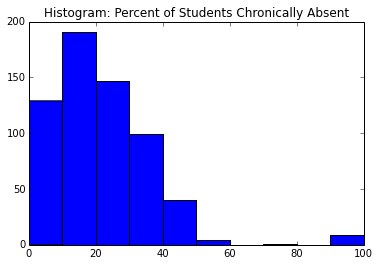

In [4]:
plt.figure(figsize = [6,4])
df_schools = df_schools.dropna(subset = ['Percent of Students Chronically Absent'])
plt.hist(df_schools['Percent of Students Chronically Absent'].values)
plt.title('Histogram: Percent of Students Chronically Absent')

In [5]:
chronically_absent_foi = ['School Name', 'Percent of Students Chronically Absent','Percent Black / Hispanic','Economic Need Index']

df_schools_ca = df_schools[df_schools['Percent of Students Chronically Absent'] > 40]
df_schools_nca = df_schools[df_schools['Percent of Students Chronically Absent'] < 40]

df_schools_ca[chronically_absent_foi].sort_values('Percent of Students Chronically Absent', ascending = False)

,School Name,Percent of Students Chronically Absent,Percent Black / Hispanic,Economic Need Index
1261,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2,100.0,98.0,0.794
1260,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 1,100.0,96.0,0.825
1206,SUCCESS ACADEMY CHARTER SCHOOL - UPPER WEST,100.0,48.0,0.369
1203,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 5,100.0,95.0,0.789
1198,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 4,100.0,94.0,0.711
1197,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 3,100.0,94.0,0.720
1196,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 2,100.0,97.0,0.734
1173,BROOKLYN LAB CHARTER SCHOOL,100.0,89.0,0.639
1121,SUCCESS ACADEMY CHARTER SCHOOL - BED-STUY 1,100.0,96.0,0.750
300,NEW DIRECTIONS SECONDARY SCHOOL,74.0,98.0,0.920


In [6]:
print('%d schools have > 40%% students chronically absent'%(df_schools_ca.shape[0]))

49 schools have > 40% students chronically absent


### School performance Indicator

Next, we explore the 6 fields in the dataset which are indicative of the overall standing of the school. These features include:
* Rigorous Instruction %
* Collaborative Teachers %
* Supportive Environment %
* Effective School Leadership %
* Strong Family-Community Ties %
* Trust %

We show some typical values of these measures below

In [7]:
features_list = ['Rigorous Instruction %',
'Collaborative Teachers %',
'Supportive Environment %',
'Effective School Leadership %',
'Strong Family-Community Ties %',
'Trust %']

# for col in features_list:
#     df_schools[col] = df_schools[col].astype(np.object).str.replace('%', '').astype(float)

df_schools[['School Name'] + features_list ].head()

,School Name,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
3,P.S. 034 FRANKLIN D. ROOSEVELT,85.0,78.0,82.0,73.0,89.0,88.0
8,P.S. 140 NATHAN STRAUS,94.0,91.0,85.0,87.0,83.0,93.0
10,P.S. 184M SHUANG WEN,90.0,81.0,91.0,67.0,83.0,85.0
11,P.S. 188 THE ISLAND SCHOOL,100.0,100.0,99.0,99.0,92.0,99.0
12,ORCHARD COLLEGIATE ACADEMY,72.0,77.0,77.0,72.0,76.0,87.0


In [8]:
df_schools[features_list].corr()

,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
Rigorous Instruction %,1.000000,0.757568,0.720514,0.643093,0.540730,0.708931
Collaborative Teachers %,0.757568,1.000000,0.594114,0.915435,0.485351,0.882959
Supportive Environment %,0.720514,0.594114,1.000000,0.488354,0.581007,0.714141
Effective School Leadership %,0.643093,0.915435,0.488354,1.000000,0.444356,0.853213
Strong Family-Community Ties %,0.540730,0.485351,0.581007,0.444356,1.000000,0.588877
Trust %,0.708931,0.882959,0.714141,0.853213,0.588877,1.000000


In [9]:
features_list =  list(set(features_list) - set(['Collaborative Teachers %','Trust %']))

Weights to each factor

1.0 Supportive Environment % (Supportive Environment Rating) <br>
0.8 Rigorous Instruction % (Rigorous Instruction Rating) <br>
0.7 Effective School Leadership % (Effective School Leadership Rating) <br>
0.5 Strong Family-Community Ties % (Strong Family-Community Ties Rating)<br>

Collaborative Teachers % (Collaborative Teachers Rating) <br>
Trust % (Trust Rating)<br>

In [10]:
features = ['Rigorous Instruction %','Supportive Environment %','Effective School Leadership %',
            'Strong Family-Community Ties %']
weights = [0.8, 1, 0.7, 0.5]

df_schools['SPI'] = df_schools[features].dot(weights)

df_schools[features+['SPI']].head(5)

,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,SPI
3,85.0,82.0,73.0,89.0,245.6
8,94.0,85.0,87.0,83.0,262.6
10,90.0,91.0,67.0,83.0,251.4
11,100.0,99.0,99.0,92.0,294.3
12,72.0,77.0,72.0,76.0,223.0


In [11]:
df_low_spi_schools = df_schools[df_schools['SPI'] < df_schools['SPI'].quantile(.25)]
df_high_spi_schools = df_schools[df_schools['SPI'] > df_schools['SPI'].quantile(.25)]

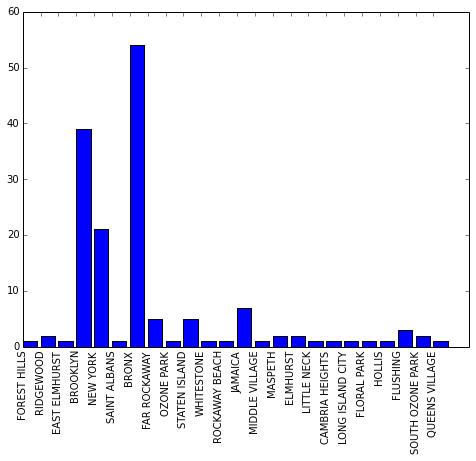

In [12]:

def plot_city_hist(df_low_spi_schools):
    df_low_spi_schools[['City']]

    # Read CSV file, get author names and counts.

    counter = Counter(df_low_spi_schools['City'])
    city = counter.keys()
    city_count = counter.values()

    # Plot histogram using matplotlib bar().
    plt.figure(figsize=[8,6])
    indexes = np.arange(len(city))
    plt.bar(indexes, city_count)
    plt.xticks(indexes , city, rotation=90)
    plt.show()
    
plot_city_hist(df_low_spi_schools)

In [13]:
df_low_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.359161
Average Math Proficiency    2.365032
dtype: float64

In [14]:
df_high_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.595393
Average Math Proficiency    2.705328
dtype: float64

### Economic Need Index

Defined as : %temp housing) + (% HRA eligible *0.5) + (% free lunch eligible *0.5). The higher the index, the higher the need

(array([  5.,  13.,  30.,  31.,  41.,  54.,  61., 135., 146., 104.]),
 array([0.059 , 0.1469, 0.2348, 0.3227, 0.4106, 0.4985, 0.5864, 0.6743,
        0.7622, 0.8501, 0.938 ]),
 <a list of 10 Patch objects>)

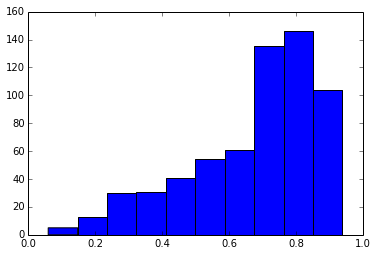

In [15]:
plt.hist(df_schools[['Economic Need Index']].values)

In [16]:
lower_bound = df_schools['Economic Need Index'].quantile(0.75)
df_schools_high_eni = df_schools[df_schools['Economic Need Index'] > lower_bound]
df_schools_low_eni = df_schools[df_schools['Economic Need Index'] < 0.25]

In [17]:
df_schools_high_eni[['School Name', 'Economic Need Index', 'Percent Black / Hispanic']].sort_values('Economic Need Index', ascending = False)

,School Name,Economic Need Index,Percent Black / Hispanic
298,NEW MILLENNIUM BUSINESS ACADEMY MIDDLE SCHOOL,0.938,98.0
283,I.S. 219 NEW VENTURE SCHOOL,0.929,98.0
1247,MOTT HAVEN ACADEMY CHARTER SCHOOL,0.928,98.0
762,BROWNSVILLE COLLABORATIVE MIDDLE SCHOOL,0.925,96.0
300,NEW DIRECTIONS SECONDARY SCHOOL,0.920,98.0
346,"P.S. 279 CAPTAIN MANUEL RIVERA, JR.",0.918,96.0
11,P.S. 188 THE ISLAND SCHOOL,0.917,93.0
299,I.S. 339,0.913,98.0
714,P.S. 288 THE SHIRLEY TANYHILL,0.912,90.0
363,M.S. 390,0.911,98.0


In [18]:
df_schools_high_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.247792
Average Math Proficiency    2.261688
dtype: float64

In [19]:
df_schools_low_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     3.267917
Average Math Proficiency    3.422083
dtype: float64

### Filtering out schools where most of the students are black / hispanic and their 4s scores are low

In [20]:
def find_schools_with_black_high_4s_low(df, grade = 5, black_per_threshold = 90, all_students_threshold = 5):
    math_black_students = "Grade {} Math 4s - Black or African American".format(grade)
    math_hispanic_students = "Grade {} Math 4s - Hispanic or Latino".format(grade)
    math_all_students = "Grade {} Math 4s - All Students".format(grade)
    
    df_schools = df.copy()
    
    df_schools['4s ratio black / hispanic'] = (df_schools[math_black_students] + df_schools[math_hispanic_students])/ df_schools[math_all_students]
    df_schools_black_4s = df_schools[np.logical_and(df_schools['Percent Black / Hispanic'] > black_per_threshold, df_schools[math_all_students] > all_students_threshold)]
    df_schools_black_4s.dropna(inplace=True)
    
    print "The following are the various statistics related to 4s score : \n"
    print df_schools_black_4s['4s ratio black / hispanic'].describe()
    
    plt.figure(figsize=[6,4])
    df_schools_black_4s['4s ratio black / hispanic'].hist()
    plt.title("Histogram : Percent of 4s scores of black/hispanic students in grade {}".format(grade))
    
    df_schools_black_4s_low = df_schools_black_4s[df_schools_black_4s['4s ratio black / hispanic'] < 0.5]
    num_schools = len(df_schools_black_4s_low)                      
    print "\n Number of schools which have poor performing black/ hispanic students in grade {} : {} \n".format(grade, num_schools)
    
    print df_schools_black_4s_low[['School Name', 'City', math_hispanic_students, math_black_students, math_all_students]]
    return df_schools_black_4s_low

In [21]:
schools_with_black_high_4s_low = []

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The following are the various statistics related to 4s score : 

count    39.000000
mean      0.710084
std       0.294419
min       0.000000
25%       0.586801
50%       0.818182
75%       0.911458
max       1.000000
Name: 4s ratio black / hispanic, dtype: float64

 Number of schools which have poor performing black/ hispanic students in grade 5 : 8 

                                            School Name      City  \
116   P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATION...  NEW YORK   
137                             P.S. 129 JOHN H. FINLEY  NEW YORK   
189                          WASHINGTON HEIGHTS ACADEMY  NEW YORK   
990                             THE GORDON PARKS SCHOOL  ROSEDALE   
1116     ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL  BROOKLYN   
1250            BRONX ACADEMY OF PROMISE CHARTER SCHOOL     BRONX   
1262                             ICAHN CHARTER SCHOOL 4     BRONX   
1271                  BRONX CHARTER SCHOOL FOR THE ARTS     BRONX   

      Grade 5 Math 4s - 

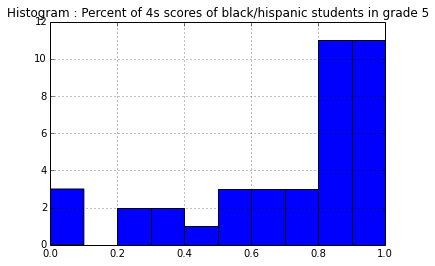

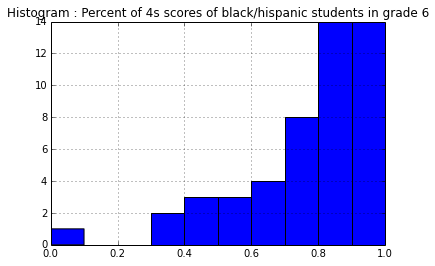

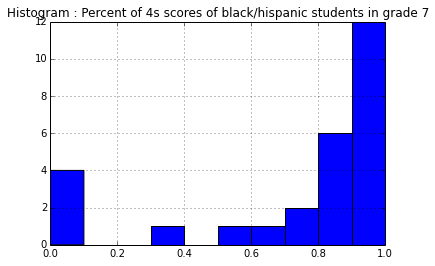

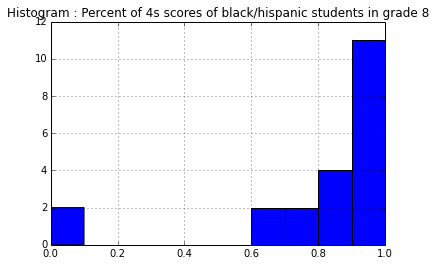

In [22]:
for grade in xrange(5,9):
    df_schools_with_black_high_4s_low = find_schools_with_black_high_4s_low(df_schools, grade=grade)
    schools_with_black_high_4s_low.extend(np.unique(df_schools_with_black_high_4s_low['School Name']))

schools_with_black_high_4s_low = list(set(schools_with_black_high_4s_low))

In [23]:
schools_with_black_high_4s_low

['P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATIONAL COMPLEX',
 'ICAHN CHARTER SCHOOL',
 'ICAHN CHARTER SCHOOL 4',
 'HARLEM VILLAGE ACADEMY LEADERSHIP CHARTER SCHOOL',
 'WASHINGTON HEIGHTS ACADEMY',
 'HARLEM PREP CHARTER SCHOOL',
 'P.S. 129 JOHN H. FINLEY',
 'BUSHWICK ASCEND CHARTER SCHOOL',
 'P.S. 235 JANICE MARIE KNIGHT SCHOOL',
 'BRONX ACADEMY OF PROMISE CHARTER SCHOOL',
 'THE GORDON PARKS SCHOOL',
 'SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2',
 'ACHIEVEMENT FIRST EAST NEW YORK CHARTER SCHOOL',
 'ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL',
 'BRONX CHARTER SCHOOL FOR THE ARTS']

In [24]:
df_filtered_schools = df_schools[df_schools['School Name'].isin(schools_with_black_high_4s_low)]
df_filtered_schools[['School Name', 'City', 'Economic Need Index', 'SPI']]

,School Name,City,Economic Need Index,SPI
116,P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATION...,NEW YORK,0.843,244.0
137,P.S. 129 JOHN H. FINLEY,NEW YORK,0.854,247.7
189,WASHINGTON HEIGHTS ACADEMY,NEW YORK,0.777,270.8
601,P.S. 235 JANICE MARIE KNIGHT SCHOOL,BROOKLYN,0.520,264.1
990,THE GORDON PARKS SCHOOL,ROSEDALE,0.358,251.9
1116,ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL,BROOKLYN,0.570,244.6
1118,ACHIEVEMENT FIRST EAST NEW YORK CHARTER SCHOOL,BROOKLYN,0.693,262.1
1171,BUSHWICK ASCEND CHARTER SCHOOL,BROOKLYN,0.760,239.3
1189,HARLEM VILLAGE ACADEMY LEADERSHIP CHARTER SCHOOL,NEW YORK,0.722,246.0
1210,HARLEM PREP CHARTER SCHOOL,NEW YORK,0.815,256.2


In [25]:
school_map = folium.Map([df_filtered_schools['Latitude'].mean(), df_filtered_schools['Longitude'].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain')

for index in df_filtered_schools.index:
    row = df_filtered_schools.loc[index]
    school_name = str(row['School Name'])
    
    color = 'blue'
    folium.Marker([row['Latitude'], row['Longitude']], popup=school_name, icon=folium.Icon(color=color)).add_to(school_map)

school_map